<a href="https://colab.research.google.com/github/SaxMan96/GitHub-Repos-BigData/blob/master/Copy_of_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Constraints

In [12]:
!pip install category_encoders

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import category_encoders as ce
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

# Defines

In [0]:
def load_data() -> pd.Series:
    csv = pd.read_csv('result.csv', sep=",")
    return csv

def del_nans(nans_perc):
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc*len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()
    
def nans_ctr() -> pd.Series:
    return csv.isna().sum()

def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv_org):
        if(csv.columns.contains(col) and (col != 'train')):
            unique.at[col] = len(csv[col].unique())
    return unique

def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv_org):
        if not csv.columns.contains(col) or col == 'train':
            continue
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == np.int32:
            val_type.at[col] = np.int32
        elif csv[col].dtype == bool:
            val_type.at[col] = bool
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print(f"No common value type found in val_types() - {csv[col].dtype}")
    return val_type

def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"min: {csv[f].min()}")
    print(f"max: {csv[f].max()}")
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")
    
def plot(data, sort=False, log=True, small=False, fontsize=7):
    if small:
        figsize = (8,4)
    else:
        figsize = (20,10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        ax = df.sort_values(by=0, ascending=False).plot(kind='bar', logy = log, figsize=figsize, legend=False)
    else:
        ax = df.plot(kind='bar', logy = log, figsize=figsize, legend=False)
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.show()
    
def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item()+1,) + t_list + (0,)
    out = data.copy()
    for i in tqdm(range(1,len(t_list)),desc="Progress",leave=False):
        idx = df[(df>t_list[i]).values & (df<=t_list[i-1]).values].index
        for j in tqdm(idx,leave=False):
            out.loc[out == j] = i
    return out

def factorize(data) -> pd.Series():
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series

def cast(data, lower_t, upper_t) -> pd.Series():
    data = data.sort_values()
    data[data<lower_t] = lower_t
    data[data>upper_t] = upper_t
    return data

def standarize(df) ->pd.Series():
    return round((df-df.min())/(df.max()-df.min()),4)

def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols = [f], handle_unknown='ignore', use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)
    
def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols = [f], handle_unknown='ignore',drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)  
def delete(f):
    global csv
    csv[f] = csv_org[f]
    csv = csv.drop(f, axis=1)

# Data Loading

In [269]:
csv = load_data()
csv_org = csv.copy()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
# del_nans(0.99)
print("Max NaNs in column left: ", max(nans))
print("Columns left after Nans removed: ", len(csv.columns))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (190,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Max NaNs in column left:  4285
Columns left after Nans removed:  221


# Data Preprocessing

In [0]:
languages = list(("NewLisp", "Max", "Liquid", "SQLPL", "Perl", "M4", "OpenEdge ABL", "XS", "Xtend", "Mirah", "SMT", "Prolog", "Ioke", "Crystal", "Haskell", "PureBasic", "Ragel in Ruby Host", "Rich Text Format", "Dockerfile", "Processing", "Erlang", "DIGITAL Command Language", "Roff", "Haxe", "Objective-J", "PLSQL", "ApacheConf", "Gnuplot", "COBOL", "Fortran", "GAP", "UnrealScript", "IDL", "Common Lisp", "PHP", "Python", "HTML", "sed", "Pascal", "C", "VCL", "Rebol", "Clojure", "PLpgSQL", "Jupyter Notebook", "Protocol Buffer", "Gherkin", "JSONiq", "Coq", "M", "HLSL", "Mathematica", "Puppet", "JavaScript", "Scheme", "MoonScript", "Scala", "Slash", "Vue", "Elixir", "SaltStack", "Yacc", "Perl 6", "Chapel", "Nim", "DM", "Batchfile", "AppleScript", "HCL", "Nu", "Ada", "C#", "Scilab", "TypeScript", "AspectJ", "SuperCollider", "F#", "CMake", "Handlebars", "LiveScript", "Clean", "Cool", "Mercury", "AGS Script", "Thrift", "POV-Ray SDL", "Inno Setup", "PigLatin", "Nginx", "Io", "Groovy", "ANTLR", "SystemVerilog", "Racket", "XSLT", "Boo", "CSS", "NSIS", "Rouge", "Mako", "ASP", "EmberScript", "R", "API Blueprint", "Rust", "XProc", "LLVM", "Shell", "PowerShell", "RobotFramework", "Pure Data", "Nemerle", "QML", "GCC Machine Description", "Forth", "Objective-C++", "ShaderLab", "OpenSCAD", "ooc", "Limbo", "Tcl", "Visual Basic", "Alloy", "Logos", "Gosu", "GLSL", "Verilog", "Arc", "Dart", "Cuda", "Pike", "Smarty", "Terra", "Stata", "Java", "ActionScript", "Hy", "Groff", "CoffeeScript", "Arduino", "xBase", "Ragel", "Graphviz (DOT)", "Objective-C", "Lex", "NetLogo", "Game Maker Language", "E", "Swift", "QMake", "Web Ontology Language", "Vim script", "Jsonnet", "RPC", "Go", "RenderScript", "Awk", "Metal", "Turing", "ColdFusion", "Eagle", "Smalltalk", "OCaml", "DTrace", "Lua", "Julia", "XQuery", "Vala", "Makefile", "Bison", "Brainfuck", "Assembly", "FreeMarker", "D", "TeX", "PostScript", "MATLAB", "GDB", "Kotlin", "SourcePawn", "Ruby", "AutoHotkey", "Emacs Lisp", "AutoIt", "HyPhy", "C++", "J", "VHDL", "Standard ML"))

In [272]:
popularLanguages=[]
for l in languages:
  if round(100*(1-nans[l]/len(csv.index)))>5.0:
    print(l, "\t", round(100*(1-nans[l]/len(csv.index))),"%")
    popularLanguages.append(l)
print(popularLanguages)

Python 	 37.0 %
HTML 	 16.0 %
C 	 13.0 %
JavaScript 	 25.0 %
CMake 	 6.0 %
CSS 	 15.0 %
Shell 	 27.0 %
Java 	 9.0 %
Makefile 	 12.0 %
Ruby 	 8.0 %
C++ 	 15.0 %
['Python', 'HTML', 'C', 'JavaScript', 'CMake', 'CSS', 'Shell', 'Java', 'Makefile', 'Ruby', 'C++']


In [294]:
f1 = "languageCounter"
f2 = "popularLanguageCounter"

csv[languages] = csv_org[languages]
csv[f1] = csv[languages].count(axis=1)
csv[f2] = csv[popularLanguages].count(axis=1)
for l in languages:
  if l in popularLanguages:
    continue
  delete(l)

csv[f1] = standarize(csv[f1])
csv[f2] = standarize(csv[f2])


csv[[f1,f2]]

,languageCounter,popularLanguageCounter
0,0.0156,0.0909
1,0.0312,0.0909
2,0.0781,0.3636
3,0.0312,0.1818
4,0.0312,0.0909
5,0.0312,0.1818
6,0.0625,0.3636
7,0.0000,0.0000
8,0.1250,0.5455
9,0.1250,0.5455


In [0]:
csv[f] = csv_org[f]
to_delete = ("Unnamed: 0", "name", "isDisabled", "isLocked", "isMirror", "isPrivate", "url", "_uri", "assign_company", "stargazer_bio", "stargazer_company", "release_isDraft", "release_isPrerelease", "_error","_error_trace")
for f in to_delete: 
  delete(f)

In [0]:
f = "name"
# stat(f)
l = list()
ctr = 0
for cell in csv[f]:
  if cell in l:
    print(cell)
    ctr += 1
  l.append(cell)
print(ctr)
# plot(csv[f],sort=True,log=False,fontsize=14)

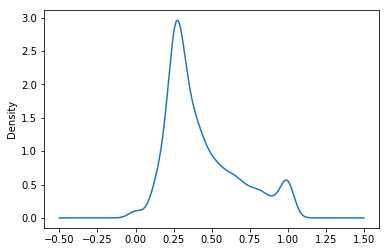

In [147]:
f = "diskUsage"
csv[f] = csv_org[f]
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = csv[f].apply(lambda x: np.power(x,1/5))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

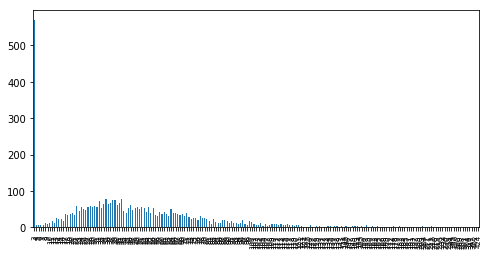

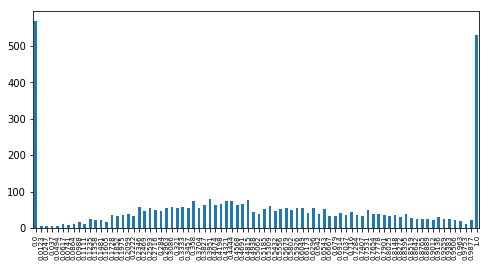

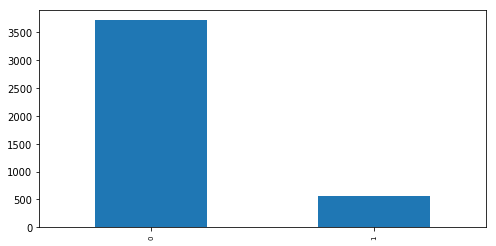

In [264]:
f = "description"
f2 = "description len"
f3 = "has description"
csv[f] = csv_org[f]
csv[f2]= csv[f].astype(str).str.len()
csv[f3]= csv[f2]>3
csv[f3] = factorize(csv[f3])
plot(csv[f2].sort_values(),sort=False,log=False,fontsize=7,small=True)
csv[f2] = cast(csv[f2],-100,2*csv[f2].median())
csv[f2] = standarize(csv[f2])
plot(csv[f2].sort_values(),sort=False,log=False,fontsize=7,small=True)
plot(csv[f3], log=False,fontsize=7,small=True)
delete(f)

min: False
max: True
nans: 0
unique: 2
val_type: <class 'bool'>
vals per class: 2143.0
79
4207


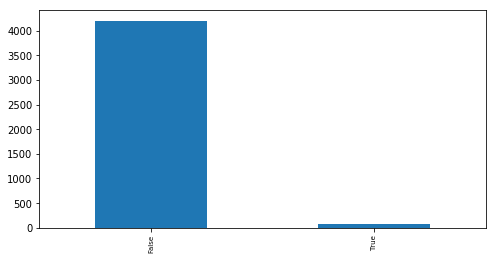

In [159]:
f = "squashMergeAllowed"
f = "isArchived"
stat(f)

csv[f] = csv_org[f]
print(len(csv[csv[f]==True]))
print(len(csv[csv[f]==False]))
# csv[f] = factorize(csv[f])
plot(csv[f].sort_values(),sort=False,log=False,fontsize=7,small=True)

In [0]:
f = "_created"

In [0]:
f = "_processed"

min: 0.0
max: 1.0
nans: 0
unique: 17
val_type: <class 'numpy.float64'>
vals per class: 252.12


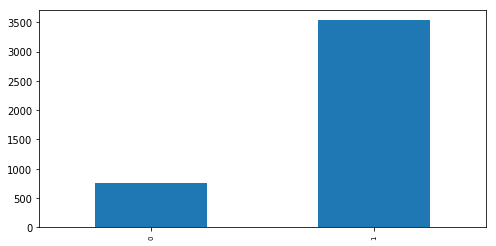

210
3534


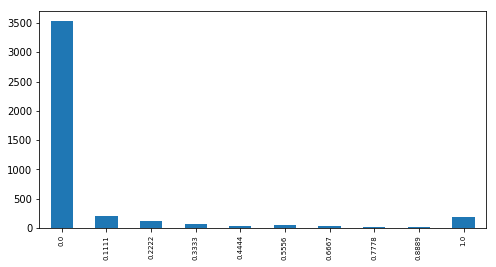

In [151]:
f = "unclosed_issues"
f2 = "has issue"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 1.0
nans: 0
unique: 128
val_type: <class 'numpy.float64'>
vals per class: 33.48


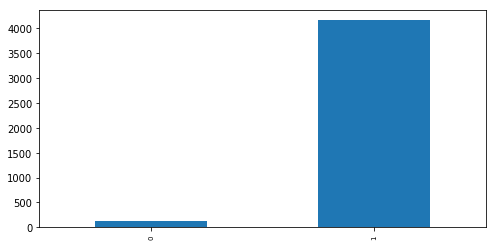

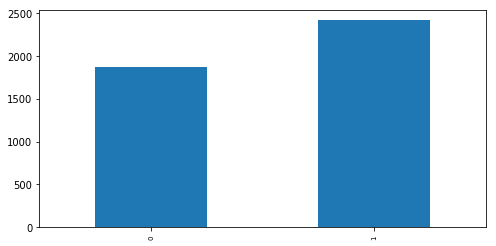

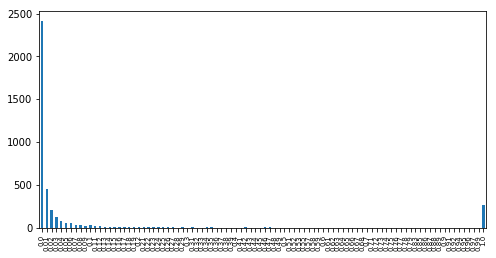

In [170]:
f = "stargazer_"
f2 = "stargazer100"
f3 = "stargazer non zero"

stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f] == 100.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

csv[f3]= csv[f] > 0.0
csv[f3] = factorize(csv[f3])
plot(csv[f3], log=False,fontsize=7,small=True)

csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 1.0
nans: 0
unique: 4
val_type: <class 'numpy.float64'>
vals per class: 1071.5


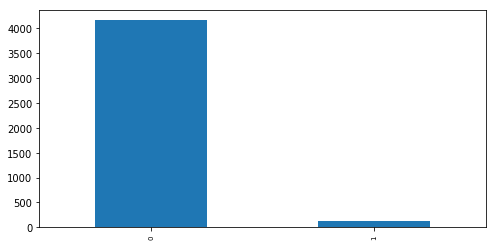

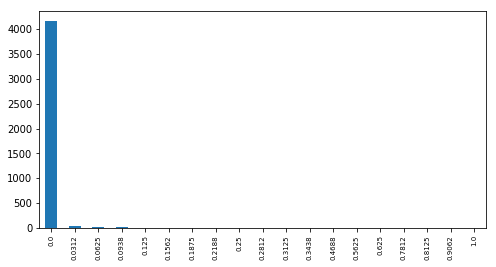

In [179]:
f = "milestone"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 31.0
nans: 0
unique: 18
val_type: <class 'numpy.float64'>
vals per class: 238.11


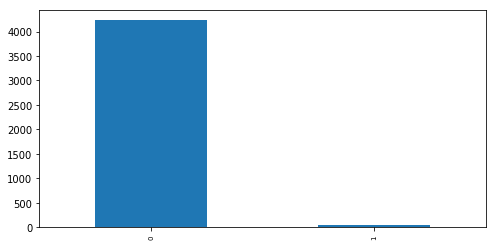

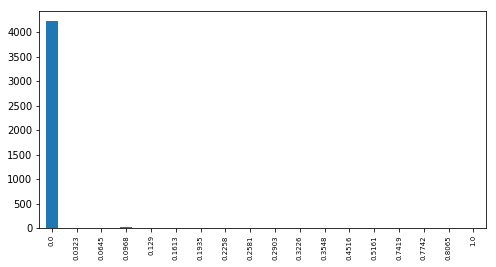

In [180]:
f = "milestone_closed"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 100.0
nans: 0
unique: 40
val_type: <class 'numpy.float64'>
vals per class: 107.15


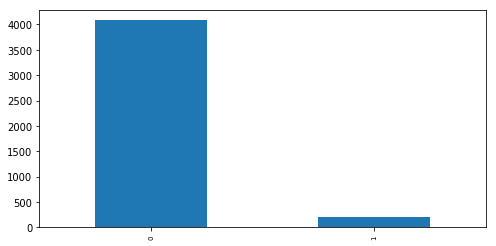

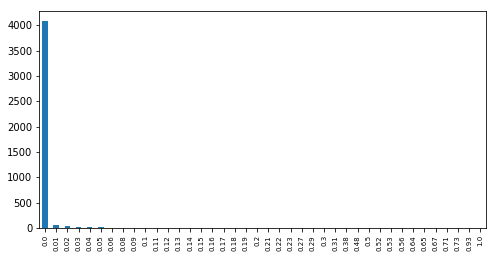

In [182]:
f = "release_"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

In [0]:
f = "release_isDraft"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

1776
2510


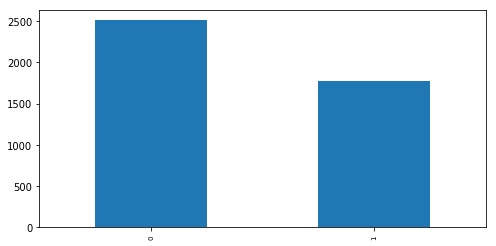

In [109]:
f = "isFork"
print(len(csv[csv[f]==True]))
print(len(csv[csv[f]==False]))
csv[f] = factorize(csv[f])
plot(csv[f].sort_values(),sort=False,log=False,fontsize=7,small=True)

In [0]:
f = 'Var178'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/5))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var177'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var176'
delete(f)

In [0]:
f = 'Var175'
delete(f)

In [0]:
f = 'Var174'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var173'
delete(f)

In [0]:
f = 'Var172'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var171'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var170'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var169'
delete(f)


In [0]:
f = 'Var168'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var167'
delete(f)

In [0]:
f = 'Var166'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var165'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var164'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var163'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()



In [0]:
f = 'Var162'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var161'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var160'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var159'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var158'
delete(f)


In [0]:
f = 'Var157'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var156'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var155'
delete(f)

In [0]:
f = 'Var154'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var153'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var152'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [0]:
f = 'Var151'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var150'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var149'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [0]:
f = 'Var148'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var147'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var146'
delete(f)

In [0]:
f = 'Var145'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var144'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var143'
delete(f)

In [0]:
f = 'Var142'
delete(f)

In [0]:
f = 'Var141'
delete(f)

In [0]:
f = 'Var140'
delete(f)

In [0]:
f = 'Var139'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var138'
delete(f)

In [0]:
f = 'Var137'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var136'
delete(f)

In [0]:
f = 'Var135'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var134'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var133'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var132'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var131'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var130'
delete(f)

In [0]:
f = 'Var129'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var128'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var127'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var126'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var125'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/4))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var124'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var123'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var122'
delete(f)

In [0]:
f = 'Var121'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var120'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var119'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var118'
delete(f)

In [0]:
f = 'Var117'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var116'
delete(f)

In [0]:
f = 'Var115'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var114'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var113'
delete(f)

In [0]:
f = 'Var112'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var111'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var110'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [0]:
f = 'Var109'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var108'
delete(f)

In [0]:
f = 'Var107'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [0]:
f = 'Var106'
delete(f)

In [0]:
f = 'Var105'
delete(f)

In [0]:
f = 'Var104'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [0]:
f = 'Var103'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [0]:
f = 'Var101'
delete(f)

In [0]:
f = 'Var100'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
# plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()

In [0]:
f = 'Var99'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var98'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()

In [0]:
f = 'Var97'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])

In [0]:
f = 'Var96'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var95'
delete(f)

In [0]:
f = 'Var94'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var93'
delete(f)

In [0]:
f = 'Var91'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var90'
delete(f)

In [0]:
f = 'Var89'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var88'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var87'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var86'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var85'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var84'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = threshold_factorization(csv[f],20000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var83'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var82'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var81'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

In [0]:
f = 'Var80'
delete(f)

In [0]:
f = 'Var78'
delete(f)

In [0]:
f = 'Var77'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var76'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var75'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var74'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.7))
csv[f] = threshold_factorization(csv[f],20000,10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)


In [0]:
f = 'Var73'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var72'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var71'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.80))
csv[f] = threshold_factorization(csv[f],12000,8000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var70'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var69'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var68'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var67'
delete(f)

In [0]:
f = 'Var66'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var65'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var63'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var62'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var61'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],8000,2000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [0]:
f = 'Var60'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var59'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var58'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),small=True)
# csv[f].plot.kde()

In [0]:
f = 'Var57'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# # plot(csv[f],small=True)

In [0]:
f = 'Var56'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [0]:
f = 'Var54'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var53'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var51'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var50'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var49'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var47'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var46'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var44'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [0]:
f = 'Var43'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var41'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var40'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var38'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [0]:
f = 'Var37'
csv[f] = csv_org[f]
stat(f)
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],9000,6000)
# plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

min: 0.0
max: 11635020.0
nans: 48421
unique: 551
val_type: <class 'numpy.float64'>
vals per class: 2.87


In [0]:
f = 'Var36'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],23)
# plot(csv[f],sort=True,small=True)
one_hot_encoding(f)

In [0]:
f = 'Var35'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var34'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var33'
delete(f)

In [0]:
f = 'Var30'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var29'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])

In [0]:
f = 'Var28'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])

In [0]:
f = 'Var27'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [0]:
f = 'Var26'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [0]:
f = 'Var25'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [0]:
f = 'Var24'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var23'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var22'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [0]:
f = 'Var21'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var19'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var18'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
csv[f] = cast(csv[f],-100,696)
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var17'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,185)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var16'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var14'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],2000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var13'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,5000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var12'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var11'
stat(f)
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

min: 8.0
max: 40.0
nans: 48760
unique: 6
val_type: <class 'numpy.float64'>
vals per class: 206.67


In [0]:
f = 'Var10'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = threshold_factorization(csv[f],1)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var9'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var7'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,56)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var6'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var5'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,7,5,4,2,1)
# plot(csv[f].sort_values(),small=True)
binary_encoding(f)

In [0]:
f = 'Var4'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(7)
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),small=True)

In [0]:
f = 'Var3'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,100,1)
# plot(csv[f].sort_values(),sort=True,small=True)
one_hot_encoding(f)

In [0]:
f = 'Var2'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
# plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

In [0]:
f = 'Var1'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

# Save Data

In [0]:
csv.to_csv("data.csv", sep=',')